# Evaluating the Chatbot


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K

/home/gloria/programs/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import (Input, Dense, Embedding, Lambda,
                                     Bidirectional, RepeatVector, Concatenate, Dot, Softmax, GaussianDropout)
from tensorflow.keras.layers import CuDNNLSTM as LSTM
from tensorflow.keras.layers import CuDNNGRU as GRU
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

In [3]:
# Set this if you want to train with attentiopn to True, otherwise False
ATTENTION = True

In [4]:
def get_cornell(foldername, encoding='ISO-8859-1'):
    """
    Loads the cornell movie dialogs.
    ----------
    INPUT:
    foldername : string - the path to the movie dialogs (relative or absolute)
    ----------
    OUTPUT:
    questions  : list - a list containing preceeding phrases
    answers    : list - a list containing following phrases 
    """
    
    # Read in dialogs
    with open(os.path.join(foldername, 'movie_lines.txt'), 'r', encoding=encoding, errors='ignore') as f:
        lines = f.read().splitlines()

    with open(os.path.join(foldername, 'movie_conversations.txt'), 'r', encoding=encoding, errors='ignore') as f:
        ids = f.read().splitlines()
        
    # Create an id to line dictionary
    split_token = ' +++$+++ '
    id2line = {l.split(split_token)[0] : l.split(split_token)[4] for l in lines}
    
    # Create a list of conversations
    conversations_ids = []
    for conv in ids[:-1]:
        _conv = conv.split(split_token)[-1][1:-1].replace("'", '').replace(" ", "")
        conversations_ids.append(_conv.split(','))
    
    # Extract 'questions' and 'answers'
    questions = [id2line[ids[i]] for ids in conversations_ids for i in range(len(ids) - 1)]
    answers = [id2line[ids[i+1]] for ids in conversations_ids for i in range(len(ids) - 1)]
    
    return questions, answers

In [5]:
class SequenceGenerator(tf.keras.utils.Sequence):
    """
    A custom sequence generator aimed at circumventing the MemoryError
    problem caused by creating large non-sparse numpy matrices. It uses keras backend.
    """
    def __init__(self, 
                 encoder_input, 
                 decoder_input, 
                 decoder_targets, 
                 batch_size=64, 
                 n_classes=None, 
                 shuffle=True,
                 attention=False,
                 latent_dim=None):
        
        
        self.batch_size = batch_size
        self.encoder_input = encoder_input
        self.decoder_input = decoder_input
        self.decoder_targets = decoder_targets
        self.n_classes = n_classes
        if self.n_classes is None:
            self.n_classes = np.max(self.decoder_targets) + 1
        self.shuffle = shuffle
        self.attention = attention
        self.latent_dim = latent_dim
        if self.attention and self.latent_dim is None:
            raise ValueError('If you are using attention, generator also needs latent dim of decoder RNN!')
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.floor(self.encoder_input.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """Generates one batch at call."""
        
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        """Sfuffle indexes after each epoch."""
        
        self.indexes = np.arange(self.encoder_input.shape[0])
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        """Generates data containing the batch samples."""
        
        # Simply select and one-hot encode the data
        encoder_input_batch = self.encoder_input[indexes, :]
        decoder_input_batch = self.decoder_input[indexes, :]
        decoder_targets_batch = self.decoder_targets[indexes, :]
        # If we are using attention, we also need to batch out the initial decoder states
        if self.attention:
            s = np.zeros((self.batch_size, self.latent_dim))
            inputs = [encoder_input_batch, decoder_input_batch, s, s]
        else:
            inputs = [encoder_input_batch, decoder_input_batch]
        outputs = to_categorical(decoder_targets_batch, num_classes=self.n_classes) 
        return (inputs, outputs)
    
    def test_generator(self, preprocessor, n_steps=3):
        """A function to test if generator is meaningful."""
        
        for i, batch in enumerate(self):
            
            (inps_batch, targets_batch) = batch
        
            print('*' * 10)
            print('Batch ', i+1)
            # If attention, we need to unpack 4 values, since the cell and hidden states are also inputs
            if self.attention:
                encoder_input_batch, decoder_input_batch, _, _ = inps_batch
            else:
                encoder_input_batch, decoder_input_batch = inps_batch
            print('Shape of encoder_input_batch: ', encoder_input_batch.shape)
            print('Shape of decoder_input_batch: ', decoder_input_batch.shape)
            print('Shape of targets_batch: ', targets_batch.shape)

            # Check dialogs
            print('Dialogs: ')
            for d in range(encoder_input_batch.shape[0]):
                print(preprocessor.decode_input_sequence(encoder_input_batch[d]))
                print(preprocessor.decode_output_sequence(decoder_input_batch[d]))
                print('-' * 20)  

            # Break after n steps
            if (i+1) % n_steps == 0:
                break
                self.on_epoch_end()

In [6]:
def load_embeddings(glove_dir, word_index, max_words, embedding_dim=100):
    """
    A function to load pre-trained embeddings and return them as a N x M numpy array.
    --------
    INPUT:
    glove_dir : string  - the path (relative or absolute to the glove vector text files)
    
    word_index : dict   - a word - index mapping obtained by a keras Tokenizer or manually
    
    max_words : int     - the maximum number of words in the vocabulary used for the application
    
    embedding_dim : int - the dimensionality of the embedding space
    ---------
    OUTPUT:
    embedding_matrix : (max_words, embedding_dim) ndarray - the matrix of embeddings which can be
                                                            directly loaded into an Embedding layer
    """
    
    
    # Create a word - vec dictionary from the pre-trained glvoe vectors
    embeddings_index = {}
    with open(os.path.join(glove_dir, 'glove.6B.100d.txt'), 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.array(values[1:], dtype='float32')
            embeddings_index[word] = coefs
            
    # Now we will build an embedding matrix that we can load into an Embedding layer.
    # It iwll be of shape (max_words, embedding_dim), where each entry i will contain
    # the embedding for the word of index i in the reference built during tokenization.
    # Index 0 is a placeholder!
    
    embedding_matrix = np.zeros((max_words, embedding_dim))
    for word, i in word_index.items():
        if i < max_words:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                
    return embedding_matrix

In [7]:
class Seq2SeqPreprocessor:
    """
    A class to bundle utility functions useful for preprocessing nlp data for a seq2seq model.
    """
    
    def __init__(self, max_seq_len=50, vocab_size=20000):
        """
        Initializes preprocessor instance.
        ----------
        INPUT:
        max_seq_len : int - defines the longest sentence allowed. If a Q or an A in a Q&A pair
                            contains more than max_seq_len, it will be later discarded.
                            
        vocab_size  : int - the maximum number of words in the vocabulary. Used by keras' Tokenizer
        """
        
        self.max_seq_len = max_seq_len
        self.vocab_size = vocab_size
        self.input_tokenizer = Tokenizer(num_words=vocab_size, filters='')
        self.output_tokenizer = Tokenizer(num_words=vocab_size, filters='')
        self.idx2word_input = {}
        self.idx2word_output = {}
        
    def clean_text(self, text):
        """
        A custom preprocessing of the input texts. It lowers the text, replaces all short 
        verb forms with their full counterparts (I'm => I am), and removes all non-alphanumeric 
        characters as well as multiple spaces with single spaces.
        ----------
        INPUT:
        text : string - a line of text to be cleaned
        ----------
        OUTPUT
        text : string - the cleaned line of text
        """
        
        # Put all lowercase
        text = text.lower()
        
        # Pronouns
        text = re.sub(r"i'm", "i am", text)
        text = re.sub(r"he's", "he is", text)
        text = re.sub(r"she's", "she is", text)
        text = re.sub(r"it's", "it is", text)
        
        # Questions
        text = re.sub(r"that's", "that is", text)
        text = re.sub(r"why's", "why is", text)
        text = re.sub(r"what's", "what is", text)
        text = re.sub(r"where's", "where is", text)
        text = re.sub(r"here's", "here is", text)
        
        # Negations
        text = re.sub(r"hasn't", "has not", text)
        text = re.sub(r"won't", "will not", text)
        text = re.sub(r"wouldn't", "would not", text)
        text = re.sub(r"shouldn't", "should not", text)
        text = re.sub(r"mustn't", "must not", text)
        text = re.sub(r"haven't", "have not", text)
        text = re.sub(r"hadn't", "had not", text)
        text = re.sub(r"can't", "cannot", text)
        text = re.sub(r"didn't", "did not", text)
        text = re.sub(r"doesn't", "does not", text)
        text = re.sub(r"don't", "do not", text)
        text = re.sub(r"aren't", "are not", text)
        
        # Modals
        text = re.sub(r"\'ll", " will", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'d", " would", text)
        
        # Keep only alphanumeric and space
        text = re.sub(r"([^\s\w]|_)+", "", text)
        # Keep only single spaces
        text = re.sub('\s+', ' ', text).strip()
        return text
    
    def _add_sos(self, text):
        return '<sos> ' + text 

    def _add_eos(self, text):
        return text + ' <eos>'  
    
    def clean_texts(self, inputs, targets):
        """
        Applies clean_text() to each input/targets pair. Adds EOS token to inputs and SOS to targets.
        ----------
        INPUT:
        inputs  - list        : a list of input sentences (strings)
        targets - list        : a list of target sentences (strings)
        ----------
        OUTPUT:
        inputs_cleaned        : list - a list of the cleaned input sentences
        targets_cleaned       : list - a list of the cleaned target sentences used as decoder output
        targets_input_cleaned : list - a list of the cleaned sentences used as decoder input (teacher forcing)
        """
        
        assert len(inputs) == len(targets), 'Input and target length must match!'
        
        # Clean inputs and targets
        inputs_cleaned = [self.clean_text(inp) for inp in inputs]
        targets_cleaned = [self.clean_text(t) for t in targets]
    
        # Remove sequences larger than max sequence length
        # First figure out indices of sentences to be removed
        idx_to_remove = []
        for i in range(len(inputs_cleaned)):
            inp_len = len(inputs_cleaned[i].split())
            target_len = len(targets_cleaned[i].split()) - 1 # we will later add eos and sos
            if inp_len > self.max_seq_len or target_len > self.max_seq_len - 1:
                idx_to_remove.append(i)
        
        # Then remove (not in-place)
        inputs_cleaned = np.delete(inputs_cleaned, idx_to_remove)
        targets_cleaned = np.delete(targets_cleaned, idx_to_remove)
        
        # Add EOS and SOS tokens, creating the input_targets list (no need for sos in decoder inputs)
        targets_cleaned = [self._add_eos(t) for t in targets_cleaned]
        targets_input_cleaned = [self._add_sos(t.replace('<eos>', '')) for t in targets_cleaned]
        
        return inputs_cleaned, targets_cleaned, targets_input_cleaned
    
    def tokenize_texts(self, inputs, targets, input_targets):
        """
        Tokenizes the three lists of cleaned texsts using keras' Tokenizer, and padds with zeros
        ----------
        INPUT:
        inputs           : list - a list of cleaned input texts (for encoder inpout)
        targets          : list - a list of cleaned target texts with EOS (decoder output)
        input_targets    : list - a list of cleaned target input texts wit SOS (decoder input)
        ----------
        OUTPUT:
        input_sequences  : np.ndarray - a N x max_seq_len numpy array with tokenized 
                                            and padded input sentences
        target_sequences : np.ndarray - a N x max_seq_len numpy array with tokenized 
                                            and padded target sentences
        target_input_sequences : np.ndarray - a N x max_seq_len numpy array with tokenized 
                                            and padded target input sentences
        """
        
        # Fit tokenizers
        self._fit_tokenizers(inputs, targets, input_targets)
        
        # Transform to sequences + padding
        input_sequences = self.tokenize_input(inputs)
        target_sequences = self.tokenize_output(targets)
        target_input_sequences = self.tokenize_output(input_targets)
        
        return input_sequences, target_sequences, target_input_sequences
        
    def _fit_tokenizers(self, inputs, targets, input_targets):
        """Utility function to separate fitting from transforming texts to sequences."""
        
        # Fit tokenizers
        self.input_tokenizer.fit_on_texts(inputs)
        self.output_tokenizer.fit_on_texts(targets + input_targets)
        
        # Obtain index 2 word dictionaries
        self.idx2word_input = {v : k for k, v in self.input_tokenizer.word_index.items()}
        self.idx2word_output = {v : k for k, v in self.output_tokenizer.word_index.items()}
        self.word2idx_input = self.input_tokenizer.word_index
        self.word2idx_output = self.output_tokenizer.word_index
        
    def tokenize_input(self, inputs):
        return pad_sequences(self.input_tokenizer.texts_to_sequences(inputs), maxlen=self.max_seq_len)
    
    def tokenize_output(self, outputs):
        return pad_sequences(self.output_tokenizer.texts_to_sequences(outputs), maxlen=self.max_seq_len, padding='post')
        
    def decode_input_sequence(self, sequence):
        """Decodes a tokenized and padded input sequence."""
        
        return ' '.join([self.idx2word_input[idx] for idx in sequence if idx != 0])
    
    def decode_output_sequence(self, sequence):
        """Decodes a tokenized and padded output sequence."""
        
        return ' '.join([self.idx2word_output[idx] for idx in sequence if idx != 0])
    
    def test_random_dialogs_raw(self, inputs, targets, num_exchanges=5):
        """A function to test by inspection if the raw dialogs are properly aligned."""

        indices = np.random.randint(0, len(inputs), num_exchanges)

        for i, idx in enumerate(indices):
            print('Random dialog {}:'.format(idx))
            print(inputs[idx])
            print(targets[idx])
            print('-' * 10)
            
    def test_random_dialogs_preprocessed(self, inputs, targets, num_exchanges=5):
        """A function to test by inspection if the preprocessed dialogs are properly aligned."""
        
        indices = np.random.randint(0, inputs.shape[0], num_exchanges)
        
        for i, idx in enumerate(indices):
            print('Random dialog {}:'.format(idx))
            print(self.decode_input_sequence(inputs[idx]))
            print(self.decode_output_sequence(targets[idx]))
            print('-' * 10)  

In [8]:
class ChatBot:
    """The ready made chat bot class utilized after training of the seq2seq model."""
    def __init__(self, preprocessor, training_model, encoder, decoder, attention, latent_dim=128):
        
        self.preprocessor = preprocessor
        self.training_model = training_model
        self.encoder = encoder
        self.decoder = decoder
        self.attention = attention
        self.latent_dim = latent_dim
        self.alphas = []
        
    def train_model(self, train_gen, val_gen, epochs, save_name, verbose=True):
        """Intereface to optimize model."""
        
        # Use checkpointing
        filepath="./checkpoints/weights-{}-best.hdf5".format(save_name)
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=True, save_best_only=True, mode='max')
        tb = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
        
        # Fit
        h = self.training_model.fit_generator(train_gen, 
                                              validation_data=val_gen, 
                                              epochs=epochs, 
                                              verbose=verbose,
                                              callbacks=[checkpoint,tb])
        
    def save_model(self, path, path_encoder, path_decoder):
        self.training_model.save_weights(path)
        self.encoder.save_weights(path_encoder)
        self.decoder.save_weights(path_decoder)
    
    def load_model(self, path, path_encoder, path_decoder):
        self.training_model.load_weights(path)
        self.encoder.load_weights(path_encoder)
        self.decoder.load_weights(path_decoder)
    
    def test_model(self, test_sentences, target_sentences, n_sentences=3, static=False):
        """Judge visually the responses of the model on test sentences (test set or custom)."""
        
        # Choose random indices.
        indices = np.random.randint(0, test_sentences.shape[0], size=n_sentences)
        decoded_targets = []
        responses = []
        for i, idx in enumerate(indices):
            decoded_input_sentence = self.preprocessor.decode_input_sequence(test_sentences[idx, :])
            decoded_target_sentence = self.preprocessor.decode_output_sequence(target_sentences[idx, :])
            
            if self.attention:
                response = self.answer_attention(decoded_input_sentence, static)
            else:
                response = self.answer(decoded_input_sentence)
            
            #print('Test ', i+1)
            #print('Input sentence: ')
            #print(decoded_input_sentence)
            #print('Chat bot output: ')
            #print(response)
            #print('Expected target sentence: ')
            #print(decoded_target_sentence)
            #print('-' * 20)
            decoded_targets.append(decoded_target_sentence[:-6].split(" ")) #discard <eos>
            responses.append(response.lower()[:-1].split(" ")) #discard "."
        return decoded_targets, responses
    
    def chat(self, static=False):
        """Chat interface."""
        
        print("Hi, let's talk!")
        print("To end the conversation, enter an empty line. :)")
        while True:
            txt = input('You: ')
            if not txt:
                print('Bye!')
                break
            if self.attention:
                response = self.answer_attention(txt, static)
            else:
                response = self.answer(txt)
            print(response)
            
    def answer_attention(self, question, static=False):
        """Answer a question with attention."""
        
        text = self.preprocessor.clean_text(question)
        encoder_output = self.encoder.predict(self.preprocessor.tokenize_input([text]))
        target_seq = np.zeros((1, 1))
        # Populate the first character of target sequence with the start character.
        target_seq[0, 0] = self.preprocessor.word2idx_output['<sos>']
        eos_idx = self.preprocessor.word2idx_output['<eos>']
        # Initial states
        s, c = np.zeros((1, self.latent_dim)), np.zeros((1, self.latent_dim))
        
        # Decoder loop
        output_sentence = []
        for _ in range(self.preprocessor.max_seq_len):
            o, s, c = self.decoder.predict([target_seq, encoder_output, s, c])
            # Index of next word
            #idx = np.argmax(o.flatten())
            o_flat = o.flatten()
            
            if static:
                sigma = 0 #don't add noise
            else:
                sigma = [0, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035]
                sigma = np.random.choice(sigma)
            
            noise = np.random.normal(0,sigma,o_flat.shape[0])
            
            o_flat = o_flat + noise
            
            idx = np.argmax(o_flat)
            
            #apply softmax so probabilities sum to 1
            #o_prob = np.exp(o_flat - np.max(o_flat))/(np.sum(np.exp(o_flat - np.max(o_flat))))
            
            #idx = [x for x in range(o_flat.shape[0])]
            #idx = np.random.choice(idx, p=o_prob)
            
            #idx = np.random.multinomial(1, idx)
            #idx = np.argmax(idx)
            
            #If EOS, end sentence
            if idx == eos_idx:
                break
            if idx > 0:
                word = self.preprocessor.idx2word_output[idx]
                output_sentence.append(word)
            # Update the decoder input which is just the word previously generated
            target_seq[0, 0] = idx
        # Try to guess if question or no (we coult have learnt that, just use for prettines)
        if len(output_sentence) == 0:
            end_char = '.'
        else:
            if output_sentence[0] in ['what', 'where', 'how', 'who', 'why', 'when', 'which', 'are']:
                end_char = '?'
            else:
                end_char = '.'
        # Return pretty sentence
        return ' '.join(output_sentence).capitalize() + end_char
        
    def answer(self, question):
        """Answer a question."""
        
        # Clean (just in case)
        text = self.preprocessor.clean_text(question)
        
        # Encode the input as state vectors.
        states = self.encoder.predict(self.preprocessor.tokenize_input([text]))
        
        # Generate empty target sequence of length 1 (language generation model)
        target_seq = np.zeros((1, 1))

        # Populate the first character of target sequence with the start character.
        target_seq[0, 0] = self.preprocessor.word2idx_output['<sos>']
        eos_idx = self.preprocessor.word2idx_output['<eos>']
        
        # Output sequence
        output_sentence = []
        for _ in range(self.preprocessor.max_seq_len):
            output_tokens, h, c = self.decoder.predict([target_seq] + states)
            # Get next word (most probable)
            idx = np.argmax(output_tokens[0, 0, :])
            #idx = np.random.multinomial(20, output_tokens[0, 0, :])
            #idx = np.argmax(idx)
            #If EOS, end sentence
            if idx == eos_idx:
                break
            if idx > 0:
                word = self.preprocessor.idx2word_output[idx]
                output_sentence.append(word)
            # Update the decoder input which is just the word previously generated
            target_seq[0, 0] = idx
            # Update states
            states = [h, c]
        # Try to guess if question or no (we coult have learnt that, just use for prettines)
        if output_sentence[0] in ['what', 'where', 'how', 'who', 'why', 'when', 'which', 'are']:
            end_char = '?'
        else:
            end_char = '.'
        # Return pretty sentence
        return ' '.join(output_sentence).capitalize() + end_char
    
    def _temperature(self, output_tokens):
        """Reweight softmax distribution."""
        
        pass

In [9]:
def create_seq2seq(preprocessor, lstm_dim=128, embedding_dim=100, 
                  dropout_rate=0.5, encoder_embeddings=None, decoder_embeddings=None):
    """Creates the seq2seq model for training and prediction."""
    
    ### TRAINING

    # Encoder input
    encoder_input = Input(shape=(preprocessor.max_seq_len, ))

    # Encoder embedding
    encoder_embedding = Embedding(
                    input_dim=preprocessor.vocab_size, 
                    output_dim=embedding_dim,
                    weights=[encoder_embeddings],
                    input_length=preprocessor.max_seq_len,
                    trainable=False
    )
    encoder_X = encoder_embedding(encoder_input)

    # Encoder LSTM
    encoder_drop = GaussianDropout(dropout_rate)(encoder_X)
    encoder_lstm = LSTM(lstm_dim, return_state=True)
    encoder_outputs, h, c = encoder_lstm(encoder_drop)

    # "Thought vector"
    encoder_states = [h, c]

    # Decoder input
    decoder_input = Input(shape=(preprocessor.max_seq_len, ))

    # Decoder embedding
    decoder_embedding = Embedding(
                input_dim=preprocessor.vocab_size, 
                output_dim=embedding_dim,
                weights=[decoder_embeddings],
                input_length=preprocessor.max_seq_len,
                trainable=False
    )      
    decoder_X = decoder_embedding(decoder_input)

    # Decoder LSTM
    decoder_drop = GaussianDropout(dropout_rate)(decoder_X)
    decoder_lstm = LSTM(lstm_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_drop, initial_state=encoder_states)

    # Softmax classifier
    decoder_dense = Dense(preprocessor.vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Model definition and compilation
    training_model = Model([encoder_input, decoder_input], decoder_outputs)
    
    ### PREDICTION MODEL
    
    # The encoder will output the initial decoder hidden state
    encoder_model = Model(encoder_input, encoder_states)

    decoder_state_input_h = Input(shape=(lstm_dim,))
    decoder_state_input_c = Input(shape=(lstm_dim,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_input_single = Input(shape=(1,))
    decoder_input_single_x = decoder_embedding(decoder_input_single)

    # this time, we want to keep the states too, to be output
    # by our sampling model
    decoder_outputs, h, c = decoder_lstm(
      decoder_input_single_x,
      initial_state=decoder_states_inputs
    )

    decoder_states = [h, c]

    decoder_outputs = decoder_dense(decoder_outputs)

    # The sampling model
    decoder_model = Model(
      [decoder_input_single] + decoder_states_inputs, 
      [decoder_outputs] + decoder_states
    )

    # Compile the training model
    training_model.compile(
      optimizer='rmsprop',
      loss='categorical_crossentropy',
      metrics=['accuracy']
    )
    
    return training_model, encoder_model, decoder_model

In [10]:
def create_attention_seq2seq(preprocessor, lstm_dim=128, embedding_dim=100, 
                  dropout_rate=0.5, encoder_embeddings=None, decoder_embeddings=None):
    """Creates the seq2seq model with attention for training and prediction."""
    
    
    ### TRAINING ###
    # -------------------------------- #
    
    ## ENCODER ##
    # Encoder input
    encoder_input = Input(shape=(preprocessor.max_seq_len, ))

    # Encoder embedding
    encoder_embedding = Embedding(
                    input_dim=preprocessor.vocab_size, 
                    output_dim=embedding_dim,
                    weights=[encoder_embeddings],
                    input_length=preprocessor.max_seq_len,
                    trainable=False
    )
    encoder_X = encoder_embedding(encoder_input)
    
    # Encoder is a bidirection lstm
    encoder_drop = GaussianDropout(dropout_rate)(encoder_X)
    encoder_lstm = Bidirectional(LSTM(lstm_dim, return_sequences=True))
    encoder_outputs  = encoder_lstm(encoder_drop)
    
    ## DECODER ##
    # Decoder input
    decoder_input = Input(shape=(preprocessor.max_seq_len, ))

    # Decoder embedding
    decoder_embedding = Embedding(
                input_dim=preprocessor.vocab_size, 
                output_dim=embedding_dim,
                weights=[decoder_embeddings],
                input_length=preprocessor.max_seq_len,
                trainable=False
    )      
    decoder_X = decoder_embedding(decoder_input)
    
    # Attention mechanism
    attn_repeat_layer = RepeatVector(preprocessor.max_seq_len)
    attn_concat_layer = Concatenate(axis=-1)
    attn_dense1 = Dense(12, activation='tanh')
    attn_dense2 = Dense(1)
    attn_softmax = Softmax(axis=1)
    attn_dot = Dot(axes=1)
    
    # Decoder LSTM
    decoder_lstm = LSTM(lstm_dim, return_state=True)
    decoder_dense = Dense(preprocessor.vocab_size, activation='softmax')
    initial_s = Input(shape=(lstm_dim, ), name='s0') # hidden state
    initial_c = Input(shape=(lstm_dim, ), name='c0') # cell state
    context_last_word_concat = Concatenate(axis=2) # use for teacher forcing
    
    # Now we obtain the output in Ty steps
    # In each step, we consider all encoder outputs and current s, and c
    s = initial_s
    c = initial_c
    
    outputs = []
    # Loop for each output step
    for t in range(preprocessor.max_seq_len):
        
        # Get context for step t
        st_1 = attn_repeat_layer(s)
        x_att = attn_concat_layer([encoder_outputs, st_1])
        alphas = attn_dense1(x_att)
        alphas = attn_dense2(alphas)
        alphas = attn_softmax(alphas)
        context = attn_dot([alphas, encoder_outputs])
        
        # Select previous word for teacher forcing
        selector = Lambda(lambda x: x[:, t:t+1])
        target_x_t = selector(decoder_X)
        
        # Combine context with previous word and get decoder output at step t
        decoder_X_t = context_last_word_concat([context, target_x_t])
        o, s, c = decoder_lstm(decoder_X_t, initial_state=[s, c])
        
        # Get next word prediction and add to outputs list
        decoder_output = decoder_dense(o)
        outputs.append(decoder_output)
        
    # Combine all the outputs from the list 
    # The list now contains Ty NxD matrices
    # where N is the batch_size and D is the vocab_size
    # Thus, we want a NxTyxD tensor => permute the stacked tensor which is TyxNxD
    output_combiner = Lambda(lambda x: K.permute_dimensions(K.stack(x), pattern=(1, 0, 2)), name='Combiner')
    outputs_stacked = output_combiner(outputs)
    
    # Create and compile the training model
    training_model = Model(
            inputs=[encoder_input, decoder_input, initial_s, initial_c],
            outputs=outputs_stacked
    )
    
    training_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    ### PREDICTION ###

    # Encoder
    encoder_model = Model(encoder_input, encoder_outputs)
    
    # Decoder (with Ty = 1)
    encoder_output_as_input = Input(shape=(preprocessor.max_seq_len, lstm_dim * 2, ))
    decoder_input_single = Input(shape=(1,))
    decoder_input_single_x = decoder_embedding(decoder_input_single)
    
    # Attention
    st_1 = attn_repeat_layer(initial_s)
    x_att = attn_concat_layer([encoder_output_as_input, st_1])
    alphas = attn_dense1(x_att)
    alphas = attn_dense2(alphas)
    alphas = attn_softmax(alphas)
    context = attn_dot([alphas, encoder_output_as_input])
    
    # Decoder lstm
    decoder_lstm_input = context_last_word_concat([context, decoder_input_single_x])
    o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s, initial_c])
    decoder_outputs = decoder_dense(o)
    
    decoder_model = Model(
        inputs=[decoder_input_single, encoder_output_as_input, initial_s, initial_c], 
        outputs=[decoder_outputs, s, c]
    )
    
    return training_model, encoder_model, decoder_model    

In [11]:
questions, answers = get_cornell('dialogs/cornell_movie-dialogs_corpus/', encoding='utf-8')
preprocessor = Seq2SeqPreprocessor(vocab_size=20000)
inputs_cleaned, targets_cleaned, targets_input_cleaned = preprocessor.clean_texts(questions, answers)
input_sequences, target_sequences, target_input_sequences = preprocessor.tokenize_texts(inputs_cleaned, 
                                                                                        targets_cleaned, 
                                                                                        targets_input_cleaned)

In [12]:
encoder_embeddings = load_embeddings('embeddings', 
                                     preprocessor.word2idx_input, 
                                     preprocessor.vocab_size)


decoder_embeddings = load_embeddings('embeddings', 
                                     preprocessor.word2idx_output, 
                                     preprocessor.vocab_size)

In [13]:
seq_gen_train = SequenceGenerator(input_sequences, 
                            target_input_sequences, 
                            target_sequences, 
                            batch_size=64, 
                            n_classes=preprocessor.vocab_size,
                            attention=ATTENTION,
                            latent_dim=128)

In [14]:
K.clear_session()


if ATTENTION:
    # Attention seq2seq
    model, encoder_model, decoder_model = create_attention_seq2seq(preprocessor, 
                                                    encoder_embeddings=encoder_embeddings, 
                                                    decoder_embeddings=decoder_embeddings)
else:
    # Vanilla seq2seq
    model, encoder_model, decoder_model = create_seq2seq(preprocessor, 
                                                        encoder_embeddings=encoder_embeddings, 
                                                        decoder_embeddings=decoder_embeddings)



In [15]:
chatbot = ChatBot(preprocessor, model, encoder_model, decoder_model, attention=ATTENTION)

In [16]:
prefix = "./weights/seq2seq_attention_"
chatbot.load_model(prefix + "weights_epoch_50.h5", prefix + "encoder_weights_epoch_50.h5", prefix + "decoder_weights_epoch_50.h5")

# Visualize attention

In [17]:
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
s0 (InputLayer)                 (None, 128)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 50, 256)      0                                            
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 50, 128)      0           s0[0][0]                         
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 50, 384)      0           input_3[0][0]                    
                                                                 repeat_vector[50][0]             
__________

## Rebuild a model identical to decoder_model, but only up to the softmax layer we want to extract results from

In [72]:
# Decoder input
decoder_input = Input(shape=(preprocessor.max_seq_len, ))

# Decoder embedding
decoder_embedding = Embedding(
            input_dim=preprocessor.vocab_size, 
            output_dim=100,
            weights=[decoder_embeddings],
            input_length=preprocessor.max_seq_len,
            trainable=False
)      
decoder_X = decoder_embedding(decoder_input)


# Attention mechanism
attn_repeat_layer = RepeatVector(preprocessor.max_seq_len)
attn_concat_layer = Concatenate(axis=-1)
attn_dense1 = Dense(12, activation='tanh')
attn_dense2 = Dense(1)
attn_softmax = Softmax(axis=1)

####

initial_s = Input(shape=(128, ), name='s0') # hidden state
initial_c = Input(shape=(128, ), name='c0') # cell state

encoder_output_as_input = Input(shape=(preprocessor.max_seq_len, 128 * 2, ))
decoder_input_single = Input(shape=(1,))
decoder_input_single_x = decoder_embedding(decoder_input_single)

# Attention
st_1 = attn_repeat_layer(initial_s)
x_att = attn_concat_layer([encoder_output_as_input, st_1])
alphas = attn_dense1(x_att)
alphas = attn_dense2(alphas)
alphas = attn_softmax(alphas)

intermediate_layer_model = Model(inputs=[decoder_input_single, encoder_output_as_input, initial_s, initial_c],
                                 outputs=alphas)

In [73]:
intermediate_layer_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
s0 (InputLayer)                 (None, 128)          0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           (None, 50, 256)      0                                            
__________________________________________________________________________________________________
repeat_vector_9 (RepeatVector)  (None, 50, 128)      0           s0[0][0]                         
__________________________________________________________________________________________________
concatenate_10 (Concatenate)    (None, 50, 384)      0           input_24[0][0]                   
                                                                 repeat_vector_9[0][0]            
__________

### Copy the weights from the decoder to our intermediate model

In [74]:
count = 0
for layer in intermediate_layer_model.layers:
    w = decoder_model.layers[count].get_weights()
    layer.set_weights(w)
    count += 1

### Talk to the model and save the softmax results/alphas/attention weights

In [236]:
def plot_attention(preprocessor, intermediate_layer_model, encoder_model, question, static=False):
    text = preprocessor.clean_text(question)
    encoder_output = encoder_model.predict(preprocessor.tokenize_input([text]))
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = preprocessor.word2idx_output['<sos>']
    eos_idx = preprocessor.word2idx_output['<eos>']
    # Initial states
    s, c = np.zeros((1, 128)), np.zeros((1, 128))

    output_sentence = []
    alphas = np.zeros((preprocessor.max_seq_len,preprocessor.max_seq_len,1))
    length_of_response = 0
    for i in range(preprocessor.max_seq_len):
        o, s, c = decoder_model.predict([target_seq, encoder_output, s, c])
        intermediate_output = intermediate_layer_model.predict([target_seq, encoder_output, s, c])
        alphas[i] = intermediate_output
    
        o_flat = o.flatten()
            
        if static:
            sigma = 0 #don't add noise
        else:
            sigma = [0, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035]
            sigma = np.random.choice(sigma)

        noise = np.random.normal(0,sigma,o_flat.shape[0])

        o_flat = o_flat + noise

        idx = np.argmax(o_flat)

        #If EOS, end sentence
        if idx == eos_idx:
            length_of_response = i
            break
        if idx > 0:
            word = preprocessor.idx2word_output[idx]
            output_sentence.append(word)
        # Update the decoder input which is just the word previously generated
        target_seq[0, 0] = idx
        
    #plot
    a = alphas.reshape((50,50))
    y_labels = text.split(" ")
    
    fig, ax1 = plt.subplots(1,1)
    img = ax1.imshow(a[:(len(y_labels)),:(len(output_sentence))])
    ax1.set_xticks(np.arange(len(output_sentence)))
    ax1.set_yticks(np.arange(len(y_labels)))
    ax1.set_xticklabels(output_sentence)
    ax1.set_yticklabels(y_labels)
    fig.colorbar(img)
    
    #return plt.gcf()

### Plot the attention weights

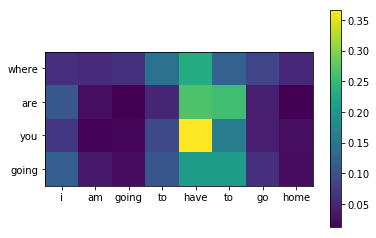

In [239]:
plot_attention(preprocessor, intermediate_layer_model, encoder_model, "Where are you going?")